# Target

- Smarthone virtual keyboard
- continuous finger motion to enter a word

# Related work

- Deep Visual-Semantic Alignments for Generating Image Descriptions; Andrej Karpathy, Li Fei-Fei
- Show, attend and tell: Neural image caption generation with visual attention; K. Xu, J. Ba, R. Kiros, K. Cho, A. Courville, R. Salakhutdinov, R.S. Zemel, Y. Bengio
- The Machine Intelligence Behind Gboard; Google Research blog

# Approach

- Deep learning tecniques for error-tolerant input
- the task is similar to image captioning hence similar architecture can be used


## Gestures generator

- it is possible to make generator of user's gestures for the samples of text from the internet and than use its outut to train a model of any complexity

### GAN as gestures generator

- gestures collection application would help to get the real user gestures dataset
- generator net produces a curve for the input word
- discriminator net gets word and corresponding curve as an input and should distinguish real user input curves from curves produced by the generator net

## Character-level RNN (LSTM) for phrase prediction

- predicts phrase character by character
- takes previous words to account
- can be trained on any text data e. g. web dumps
- can predict quotes, commas, semicolons, dots etc.
- see also [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Neural network architecture

- input: full gesture points sequience, repeated N times
  - code of the underlaying letter can be added as an additional coordinate for each point of sequence
- output: letters, one letter per one repeat

## Gestures CNN layers

- gesture points are time-ordered, hence it is reasonable to consider input for CNN layer as ordered array of 2D points
  - first filter gets points 1-10, second filter gets points 2-11 etc.
  - 3D points could be used if underlaying letter code is added to gesture points

## Attention

- attention layers can be used to select the right part of the curve for current letter
- see also [Attention Mechanism](https://blog.heuritech.com/2016/01/20/attention-mechanism/)



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw

In [11]:
%run keymagic.py

In [4]:
keyboard_img = 'ios-7-1-keyboard.jpg'

In [5]:
kbrd = keyboardIOS7()

In [6]:
def draw_keyboard(kbrd, img_path):
    im = Image.open(img_path)

    draw = ImageDraw.Draw(im)

    for pos, sz in kbrd.values():
        bl = (pos[0], pos[1] + sz[1])
        br = (pos[0] + sz[0], pos[1] + sz[1])
        ur = (pos[0] + sz[0], pos[1])
        draw.line([pos, ur, br, bl, pos], (220, 100, 0), width=3)
        
    return im

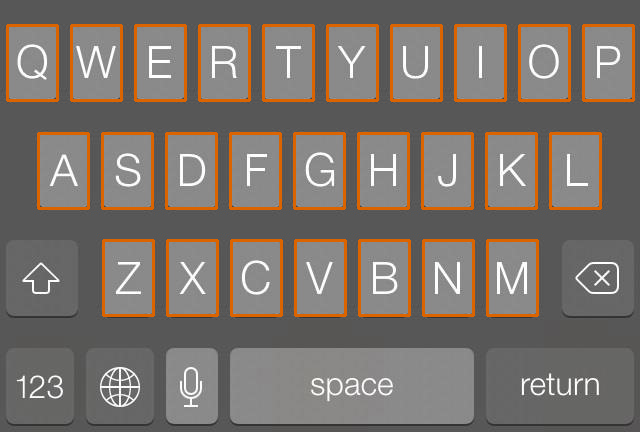

In [7]:
draw_keyboard(kbrd, keyboard_img)

In [9]:
def draw_word_line(word_line, img_path):
    im = Image.open(img_path)

    draw = ImageDraw.Draw(im)

    draw.line(word_line, (220, 100, 0), width=3)
        
    return im

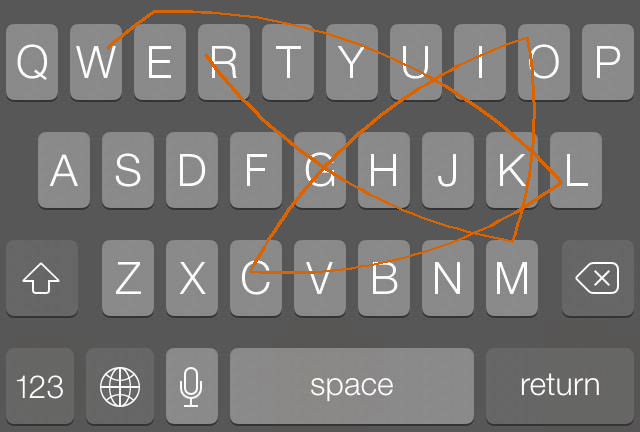

In [12]:
draw_word_line(word_to_line(kbrd, 'welcome', 20), keyboard_img)

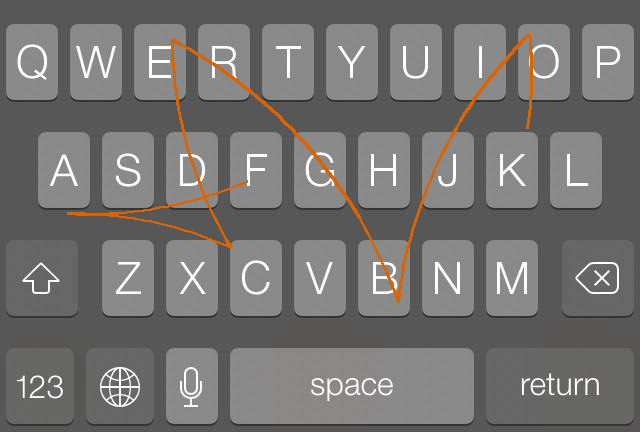

In [13]:
draw_word_line(word_to_line(kbrd, 'facebook', 20), keyboard_img)

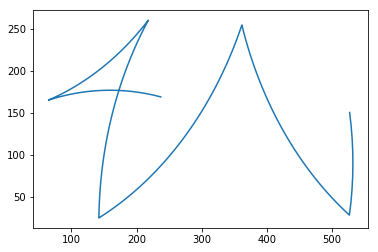

In [14]:
curve = word_to_line(kbrd, 'facebook', 20)
x, y = zip(*curve)
plt.plot(x, y)

In [15]:
def key_matrix(kbrd, img_path, char_indices):
    with Image.open(keyboard_img) as im:
        im_sz = im.size
    
    key_matrix = np.zeros(im.size, dtype=np.byte)
    key_matrix.fill(-1)
    
    for k, (pos, sz) in kbrd.items():
        key_matrix[pos[0]:pos[0]+sz[0], pos[1]:pos[1]+sz[1]] = char_indices[k]
        
    return key_matrix

In [31]:
char_indices = dict((c, i) for i, c in enumerate(kbrd.keys()))

km = key_matrix(kbrd, keyboard_img, char_indices)

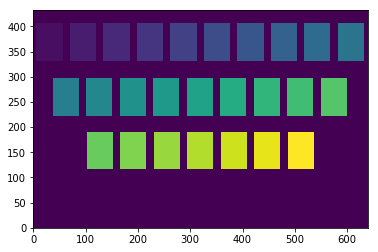

In [30]:
plt.pcolor(np.flipud(km.T))